In [273]:
CT_LIST = ['ESC', 'MES', 'CP', 'CM']
HM_LIST = ['H3K4me3', 'H3K27ac', 'H3K27me3',  'RNA']
PREFIXES = [HM + '_' + CT for HM in HM_LIST for CT in CT_LIST]


MARKER_GENES_EXT = {'ESC': ['Nanog','Pou5f1','Sox2','L1td1','Dppa5a','Tdh','Esrrb','Lefty1','Zfp42','Sfn','Lncenc1','Utf1'],
                    'MES': ['Mesp1','Mesp2','T', 'Vrtn','Dll3','Dll1', 'Evx1','Cxcr4','Pcdh8','Pcdh19','Robo3','Slit1'],
                    'CP':  ['Sfrp5', 'Gata5', 'Tek','Hbb-bh1','Hba-x', 'Pyy','Sox18','Lyl1','Rgs4','Igsf11','Tlx1','Ctse'],
                    'CM':  ['Nppa','Gipr', 'Actn2', 'Coro6', 'Col3a1', 'Bgn','Myh6','Myh7','Tnni3','Hspb7' ,'Igfbp7','Ndrg2'],
                    }



HM_COL_DICT = {'H3K4me3': '#f37654','H3K27ac': '#b62a77','H3K27me3': '#39A8AC','RNA':'#ED455C'}
CT_COL_DICT= {'ESC': '#405074',
                'MES': '#7d5185',
                'CP': '#c36171',
                'CM': '#eea98d',}
SET_COL_DICT= {'training':'#97DA58','validation':'#9b58da','test':'#DA5A58'}
GONZALEZ_COL_DICT= {'Active': '#E5AA44','Bivalent': '#7442BE'}

In [274]:
import plotly.express as px
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns



# Load gene cluster dictionary
with open(f'./data/gene_clusters_dict.pkl', 'rb') as f:
    GENE_CLUSTERS = pickle.load(f)

# Load CODE and LOG matrices
CODE = pd.read_csv(f'./data/CODE.csv', index_col='GENE')
CODE = CODE.iloc[:, 18:]
CODE.drop(columns=['AE_RMSE','AE_Sc', 'PCA_RMSE', 'PCA_Sc', 'UMAP_RMSE', 'UMAP_Sc'],inplace=True)
LOG = pd.read_csv(f'./data/ALL_X_FC.csv').set_index('GENE')


In [275]:
name = 'TOP'
N_TOP = 4000
with open(f'./data/RNA_CV/{name}{N_TOP}/dict.pkl', 'rb') as f:
    CV = pickle.load(f)
name = 'BOTTOM'
with open(f'./data/RNA_CV/{name}{N_TOP}/dict.pkl', 'rb') as f:
    BOTTOM_CV = pickle.load(f)
    
STABLE = [gene for gene_list in BOTTOM_CV.values() for gene in gene_list]
CV['STABLE'] = STABLE

CV_MAP={}
for CV_CAT, gene_list in CV.items():
    for gene in gene_list:
        CV_MAP[gene] = CV_CAT
        
CODE["CV_Category"] = CODE.index.map(CV_MAP)
CODE['CV_Category'] = CODE['CV_Category'].fillna('other')

In [276]:
with open('./data/gonzalez_dict.pkl', 'rb') as f:
    GONZALEZ = pickle.load(f)
GONZALEZ_MAP={}
for GONZALEZ_CAT, gene_list in GONZALEZ.items():
    for gene in gene_list:
        GONZALEZ_MAP[gene] = GONZALEZ_CAT
CODE["ESC_ChromState_Gonzalez2021"] = CODE.index.map(GONZALEZ_MAP)
CODE['ESC_ChromState_Gonzalez2021'] = CODE['ESC_ChromState_Gonzalez2021'].fillna('other')
CODE['ESC_ChromState_Gonzalez2021'].value_counts()

ESC_ChromState_Gonzalez2021
Active      9186
other       3495
Bivalent    2315
Name: count, dtype: int64

In [277]:

# Map cluster IDs to CODE and LOG
gene_to_cluster = {}
for cluster_id, gene_list in GENE_CLUSTERS.items():
    for gene in gene_list['gene_list']:
        gene_to_cluster[gene] = cluster_id
CODE["Cluster"] = CODE.index.map(gene_to_cluster).astype(int)


In [278]:
CODE = CODE[['Cluster','RNA_CV','CV_Category', 'ESC_ChromState_Gonzalez2021',
                'RNA_ESC', 'RNA_MES', 'RNA_CP', 'RNA_CM',

    'H3K4me3_ESC','H3K4me3_MES', 'H3K4me3_CP', 'H3K4me3_CM', 'H3K27ac_ESC', 'H3K27ac_MES',
        'H3K27ac_CP', 'H3K27ac_CM', 'H3K27me3_ESC', 'H3K27me3_MES',
        'H3K27me3_CP', 'H3K27me3_CM', 
        
        'RNA_CM_CP_FC', 'RNA_CM_MES_FC', 'RNA_CM_ESC_FC', 'RNA_CP_MES_FC','RNA_CP_ESC_FC', 'RNA_MES_ESC_FC', 
        'VAE_RMSE', 'VAE_Sc', 
        
        'VAE1', 'VAE2', 'VAE3', 'VAE4', 'VAE5', 'VAE6', 'VAE_UMAP1', 'VAE_UMAP2',]]
CODE['Cluster'] = pd.Categorical(CODE['Cluster'])

In [279]:
# import pca
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



tmp = CODE[['VAE1', 'VAE2', 'VAE3', 'VAE4', 'VAE5', 'VAE6']]

# Standardize the data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(tmp)

# Apply PCA
pca = PCA(n_components=2)
pca_data = pca.fit_transform(tmp)

# Calculate explained variance percentage
explained_variance = pca.explained_variance_ratio_ * 100
pca_columns = [f'VAE_PCA{i+1}({explained_variance[i]:.0f}%)' for i in range(2)]
# Create a DataFrame for the PCA components
pca_df = pd.DataFrame(pca_data, columns=pca_columns,
                            index=CODE.index) 


In [280]:
DATA = pd.concat([CODE, pca_df], axis=1)


In [281]:
DATA.columns

Index(['Cluster', 'RNA_CV', 'CV_Category', 'ESC_ChromState_Gonzalez2021',
       'RNA_ESC', 'RNA_MES', 'RNA_CP', 'RNA_CM', 'H3K4me3_ESC', 'H3K4me3_MES',
       'H3K4me3_CP', 'H3K4me3_CM', 'H3K27ac_ESC', 'H3K27ac_MES', 'H3K27ac_CP',
       'H3K27ac_CM', 'H3K27me3_ESC', 'H3K27me3_MES', 'H3K27me3_CP',
       'H3K27me3_CM', 'RNA_CM_CP_FC', 'RNA_CM_MES_FC', 'RNA_CM_ESC_FC',
       'RNA_CP_MES_FC', 'RNA_CP_ESC_FC', 'RNA_MES_ESC_FC', 'VAE_RMSE',
       'VAE_Sc', 'VAE1', 'VAE2', 'VAE3', 'VAE4', 'VAE5', 'VAE6', 'VAE_UMAP1',
       'VAE_UMAP2', 'VAE_PCA1(43%)', 'VAE_PCA2(18%)'],
      dtype='object')

In [282]:
DR = 'PCA'
COMPONENTS = [col for col in DATA.columns if f'{DR}' in col]
COMPONENTS

['VAE_PCA1(43%)', 'VAE_PCA2(18%)']

In [283]:
RNA_FPKM= pd.read_csv(f'./data/RNA_FPKMs.csv', index_col='GENE')
assert list(RNA_FPKM.index) == list(DATA.index)
#concatenate the two dataframes
DATA = pd.concat([DATA, RNA_FPKM], axis=1)
DATA.to_csv(f'./data/DATA.csv')

Z_AVG_features = ['RNA_ESC', 'RNA_MES', 'RNA_CP', 'RNA_CM', 'H3K4me3_ESC', 'H3K4me3_MES',
        'H3K4me3_CP', 'H3K4me3_CM', 'H3K27ac_ESC', 'H3K27ac_MES', 'H3K27ac_CP',
        'H3K27ac_CM', 'H3K27me3_ESC', 'H3K27me3_MES', 'H3K27me3_CP',
        'H3K27me3_CM']
LOG_FC_features = ['RNA_CM_CP_FC', 'RNA_CM_MES_FC', 'RNA_CM_ESC_FC',
            'RNA_CP_MES_FC', 'RNA_CP_ESC_FC', 'RNA_MES_ESC_FC']

MISC_features = [ 'VAE_RMSE', 'VAE_Sc', 'RNA_CV', 'CV_Category', 'ESC_ChromState_Gonzalez2021', 'Cluster']

LATENT_features = ['VAE1', 'VAE2', 'VAE3', 'VAE4', 'VAE5', 'VAE6', 'VAE_UMAP1', 'VAE_UMAP2', pca_columns[0], pca_columns[1]]

FPKM_features = [ 'RNA_ESC_1', 'RNA_ESC_2', 'RNA_MES_1', 'RNA_MES_2',
            'RNA_CP_1', 'RNA_CP_2', 'RNA_CM_1', 'RNA_CM_2']


Z_AVG = DATA[Z_AVG_features]

LOG_FC = DATA[LOG_FC_features]

MISC = DATA[MISC_features]

LATENT = DATA[LATENT_features]

FPKM = DATA[FPKM_features]


In [284]:
FPKM = DATA.filter(FPKM_features)


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import numpy as np
import pandas as pd



In [285]:
def plot_sankey(DATA, SEL_GENES, FEATURE_CAT, COL_DICT, font_size=12, font_color="black", font_family="Arial", link_opacity=0.5):
    """
    Create a Sankey diagram with FEATURE_CAT as the first layer, genes as the second, and clusters as the last.
    Links between FEATURE_CAT and clusters are colored based on FEATURE_CAT.

    Parameters:
    - DATA (pd.DataFrame): Input data with genes as index.
    - SEL_GENES (list): List of selected gene names.
    - FEATURE_CAT (str): The column name for categorical features to add as the first layer.
    - COL_DICT (dict): A dictionary mapping FEATURE_CAT values to colors in hex format.
    - font_size (int): Font size for node labels.
    - font_color (str): Font color for node labels.
    - font_family (str): Font family for node labels.
    - link_opacity (float): Opacity for the links (0.0 to 1.0).

    Returns:
    - fig: A Plotly Sankey figure.
    """
    import matplotlib.colors as mcolors

    if FEATURE_CAT not in DATA.columns:
        raise ValueError(f"The feature '{FEATURE_CAT}' is not in the provided DATA.")

    # Filter for selected genes
    data_filtered = DATA.loc[SEL_GENES]

    # Create node labels
    feature_nodes = data_filtered[FEATURE_CAT].unique().tolist()  # FEATURE_CAT as the first level
    gene_nodes = SEL_GENES  # Gene names as the second level
    cluster_nodes = data_filtered["Cluster"].unique().tolist()  # Clusters as the last level

    all_nodes = feature_nodes + gene_nodes + cluster_nodes  # Combine all nodes
    node_map = {node: i for i, node in enumerate(all_nodes)}  # Map node name to index

    # Create links
    links = []
    link_colors = []

    # Links from FEATURE_CAT to genes
    for gene, row in data_filtered.iterrows():
        feature_value = row[FEATURE_CAT]
        links.append({
            "source": node_map[feature_value],
            "target": node_map[gene],
            "value": 1  # Equal weight for all links
        })
        link_colors.append("rgba(192,192,192,0.3)")  # Light gray for FEATURE_CAT-to-gene links

    # Links from genes to clusters
    for gene, row in data_filtered.iterrows():
        cluster = row["Cluster"]
        feature_value = row[FEATURE_CAT]
        hex_color = COL_DICT.get(feature_value, "#808080")  # Default to gray
        rgba_color = mcolors.to_rgba(hex_color, alpha=link_opacity)  # Convert hex to RGBA
        rgba_str = f"rgba({int(rgba_color[0]*255)}, {int(rgba_color[1]*255)}, {int(rgba_color[2]*255)}, {rgba_color[3]})"
        links.append({
            "source": node_map[gene],
            "target": node_map[cluster],
            "value": 1  # Equal weight for all links
        })
        link_colors.append(rgba_str)

    # Define node colors
    node_colors = []
    for node in all_nodes:
        if node in feature_nodes:  # FEATURE_CAT nodes
            node_colors.append(COL_DICT.get(node, "#808080"))  # Color by FEATURE_CAT
        elif node in gene_nodes:  # Gene nodes
            node_colors.append("silver")  # Default gray for genes
        else:  # Cluster nodes
            node_colors.append("silver")  # Light blue for clusters

    # Create Sankey diagram
    fig = go.Figure(go.Sankey(
        textfont=dict(size=font_size, color=font_color,shadow=None) ,
        node=dict(
            pad=5,
            thickness=10,
            line=dict(color="black", width=0.5),
            label=all_nodes,
            color=node_colors,
            hovertemplate='%{label}<extra></extra>',
            
            
        ),
        link=dict(
            source=[link["source"] for link in links],
            target=[link["target"] for link in links],
            value=[link["value"] for link in links],
            color=link_colors,# Colored links between FEATURE_CAT and clusters
            hovertemplate='Gene: %{source.label}<br>Cluster: %{target.label}',
        )
    ))


    # Update layout
    fig.update_layout(
        title_text="",
        margin=dict(t=50, l=25, r=25, b=25),
    )
    # Add titles for layers
    fig.add_annotation(x=0.02, y=1.1, text="Category", showarrow=False, font=dict(size=16))
    fig.add_annotation(x=0.5, y=1.1, text="Gene", showarrow=False, font=dict(size=16))
    fig.add_annotation(x=0.98, y=1.1, text="Cluster", showarrow=False, font=dict(size=16), xanchor='right')

    return fig


In [286]:
SEL_GENES=['Nanog','Pou5f1','Sox2','Dppa5a','Mesp1','T', 'Vrtn','Dll3','Gata5', 'Tek','Sox18','Lyl1','Actn2', 'Coro6','Myh6','Myh7']
CAT_FEATURE = 'CV_Category'
COL_DICT =  {'RNA_ESC': '#405074',
                'RNA_MES': '#7d5185',
                'RNA_CP': '#c36171',
                'RNA_CM': '#eea98d',
                'STABLE':'#B4CD70',
                'other':'#ECECEC'}




fig = plot_sankey(DATA, SEL_GENES, CAT_FEATURE, COL_DICT, font_color='white', font_size=14,link_opacity=0.9)
fig


ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'link': {'color': [rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(192,192,192,0.3), rgba(192,192,192,0.3),
                                 rgba(64, 80, 116, 0.9), rgba(64, 80, 116, 0.9),
                                 rgba(64, 80, 116, 0.9), rgba(64, 80, 116, 0.9),
                                 rgba(125, 81, 133, 0.9), rgba(125, 81, 133, 0.9),
                                 rgba(125, 81, 133, 0.9), rgba(125, 81, 133, 0.9),
                                 rgba(195, 97, 113, 0.9), rgba(195, 97, 113, 0.9),
                                 rgba(195, 97, 113, 0.9), rgba(195, 97, 113, 0.9),
                                 rgba(238, 169, 141, 0.9), rgba(238, 169, 141,
                                 0.9), rgba(238, 169, 141, 0.9), rgba(238, 169,
                                 141, 0.9)],
                       'hovertemplate': 'Gene: %{source.label}<br>Cluster: %{target.label}',
                       'source': [0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3,
                                  4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                  18, 19],
                       'target': [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16,
                                  17, 18, 19, 20, 21, 22, 20, 23, 21, 23, 23, 24,
                                  25, 24, 24, 26, 27, 26, 26],
                       'value': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
                                 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]},
              'node': {'color': [#405074, #7d5185, #c36171, #eea98d, silver,
                                 silver, silver, silver, silver, silver, silver,
                                 silver, silver, silver, silver, silver, silver,
                                 silver, silver, silver, silver, silver, silver,
                                 silver, silver, silver, silver, silver],
                       'hovertemplate': '%{label}<extra></extra>',
                       'label': [RNA_ESC, RNA_MES, RNA_CP, RNA_CM, Nanog, Pou5f1,
                                 Sox2, Dppa5a, Mesp1, T, Vrtn, Dll3, Gata5, Tek,
                                 Sox18, Lyl1, Actn2, Coro6, Myh6, Myh7, 39, 53, 29,
                                 48, 17, 22, 70, 68],
                       'line': {'color': 'black', 'width': 0.5},
                       'pad': 5,
                       'thickness': 10},
              'textfont': {'color': 'white', 'size': 14},
              'type': 'sankey'}],
    'layout': {'annotations': [{'font': {'size': 16}, 'showarrow': False, 'text': 'Category', 'x': 0.02, 'y': 1.1},
                               {'font': {'size': 16}, 'showarrow': False, 'text': 'Gene', 'x': 0.5, 'y': 1.1},
                               {'font': {'size': 16},
                                'showarrow': False,
                                'text': 'Cluster',
                                'x': 0.98,
                                'xanchor': 'right',
                                'y': 1.1}],
               'margin': {'b': 25, 'l': 25, 'r': 25, 't': 50},
               'template': '...',
               'title': {'text': ''}}
})

In [287]:
def plot_boxplots_clusters(df, CLUSTER_COL, FEATURE_PREFIXES, HM_COL_DICT=None, X_LINE=0, TITLE=None, X_LAB='Z-score'):
    # Get unique GMM_LABELS
    unique_labels = df[CLUSTER_COL].sort_values().unique()
    num_labels = len(unique_labels)
    VMIN, VMAX = df[FEATURE_PREFIXES].min().min(), df[FEATURE_PREFIXES].max().max()

    MAPPED_COL = None
    if HM_COL_DICT is not None:
        MAPPED_COL = list(map(lambda x: next((v for k, v in HM_COL_DICT.items() if k in x), None), FEATURE_PREFIXES))

    # Update layout for halved columns
    num_rows = 10  # Updated to maintain the same number of total plots
    num_cols = (num_labels + num_rows - 1) // num_rows  # Adjust to get fewer columns
    
    # Set up subplots with updated figsize and column count
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(2 * num_cols, 4 + num_rows * len(FEATURE_PREFIXES) * 0.20))
    
    plt.suptitle(TITLE, fontsize=20, y=1.02)
    # Iterate over each unique value of GMM_LABELS
    for idx, label in enumerate(unique_labels):
        # Subset the dataframe for the current label
        subset_df = df[df[CLUSTER_COL] == label]
        num_genes = subset_df.shape[0]
        # Melt the dataframe to long format for seaborn
        melted_df = subset_df.melt(id_vars=CLUSTER_COL, value_vars=FEATURE_PREFIXES, var_name='HM')
        # Plot the boxplot
        col_index = idx % num_cols
        row_index = idx // num_cols

        sns.violinplot(ax=axes[row_index, col_index], y='HM', x='value', data=melted_df, hue='HM', palette=MAPPED_COL, saturation=0.8,
                        width=0.7, inner=None, linewidth=0, cut=1)
        plt.setp(axes[row_index, col_index].collections, alpha=.8)

        sns.boxplot(ax=axes[row_index, col_index], y='HM', x='value', data=melted_df, hue='HM', palette=MAPPED_COL,
                    width=0.3, linewidth=1, showcaps=1,
                    medianprops={"color": "w", "linewidth": 1},
                    boxprops=dict(facecolor="black", alpha=0.4),
                    whiskerprops=dict(color="black", alpha=0.5),
                    flierprops=dict(marker='.', markerfacecolor='grey', markersize=1, alpha=0.5))
        # Set title and labels
        axes[row_index, col_index].set_title(f'C{label} ({num_genes})', size=15)
        axes[row_index, col_index].set_ylabel('')
        axes[row_index, col_index].axvline(x=X_LINE, color='black', linestyle='-', linewidth=0.5)

        # Set y limits equal for all plots
        axes[row_index, col_index].set_xlim(VMIN, VMAX)  # Adjust the limits as per your data range
        if row_index == (num_labels // num_cols) - 1:
            axes[row_index, col_index].set_xlabel(X_LAB, fontsize=12)
        else:
            axes[row_index, col_index].set_xlabel('')
        # Remove y-axis label for all but the first plot
        if col_index != 0:
            axes[row_index, col_index].set_yticklabels('')

        # Change the size of xticklabels
        for tick in axes[row_index, col_index].get_xticklabels():
            tick.set_fontsize(12)  # Change xtick label size

    # Hide any unused subplots
    for i in range(idx + 1, num_rows * num_cols):
        fig.delaxes(axes.flat[i])

    plt.tight_layout()


In [288]:
HM_LIST = ['H3K4me3', 'H3K27ac', 'H3K27me3']

In [289]:
for HM in HM_LIST:
    HM_Z = DATA[Z_AVG_features].filter(regex=f'{HM}').columns 
    print(HM_Z)

Index(['H3K4me3_ESC', 'H3K4me3_MES', 'H3K4me3_CP', 'H3K4me3_CM'], dtype='object')
Index(['H3K27ac_ESC', 'H3K27ac_MES', 'H3K27ac_CP', 'H3K27ac_CM'], dtype='object')
Index(['H3K27me3_ESC', 'H3K27me3_MES', 'H3K27me3_CP', 'H3K27me3_CM'], dtype='object')


Feature columns: ['H3K4me3_ESC', 'H3K4me3_MES', 'H3K4me3_CP', 'H3K4me3_CM']
Filtered DataFrame for cluster 32: 14996 rows
Melted DataFrame head:
    CT     Value
0  ESC -1.214507
1  ESC -0.701693
2  ESC -1.305114
3  ESC -0.548835
4  ESC -1.133662


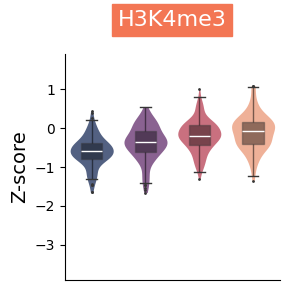

Feature columns: ['H3K27ac_ESC', 'H3K27ac_MES', 'H3K27ac_CP', 'H3K27ac_CM']
Filtered DataFrame for cluster 32: 14996 rows
Melted DataFrame head:
    CT     Value
0  ESC -1.407116
1  ESC -1.543512
2  ESC -1.525385
3  ESC -1.444067
4  ESC -1.746531


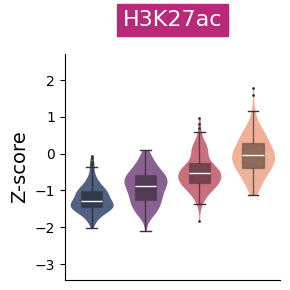

Feature columns: ['H3K27me3_ESC', 'H3K27me3_MES', 'H3K27me3_CP', 'H3K27me3_CM']
Filtered DataFrame for cluster 32: 14996 rows
Melted DataFrame head:
    CT     Value
0  ESC  0.960936
1  ESC  0.898823
2  ESC  0.660102
3  ESC  1.308094
4  ESC  1.123466


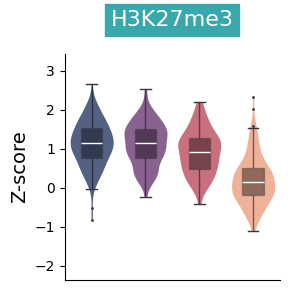

In [290]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_violin_box(df, feature_group, ct_list, hm_col_dict, ct_col_dict, k=None, x_lab='Value Distribution', vmin=None, vmax=None):
    """
    Plots a violin and box plot for a single feature group, with values colored and grouped by `ct_list`.

    Args:
        df (pd.DataFrame): The data frame containing the data.
        feature_group (str): The feature group to be plotted (e.g., 'H3K4me3').
        ct_list (list of str): List of cell types for grouping (e.g., ['ESC', 'MES', 'CP', 'CM']).
        hm_col_dict (dict): Dictionary mapping feature groups to colors.
        ct_col_dict (dict): Dictionary mapping cell types to colors.
        k (int, optional): Cluster value to filter the DataFrame by the 'Cluster' column.
        x_lab (str): Label for the x-axis.
    """
    

    # Filter columns specific to the feature group and the time points
    feature_columns = [f"{feature_group}_{ct}" for ct in ct_list]
    filtered_df = df[feature_columns].copy()
    print(f"Feature columns: {feature_columns}")

    VMIN, VMAX = filtered_df.min().min(), filtered_df.max().max()


    # Filter rows by cluster value if k is provided
    if k is not None:
        filtered_df = filtered_df[df['Cluster'] == k]
        print(f"Filtered DataFrame for cluster {k}: {df.shape[0]} rows")
        
    # Melt the DataFrame to long format for plotting
    melted_df = filtered_df.melt(var_name='CT', value_name='Value')
    melted_df['CT'] = melted_df['CT'].str.replace(f"{feature_group}_", '')
    print(f"Melted DataFrame head:\n{melted_df.head()}")

    # Create the plot
    fig, ax = plt.subplots(figsize=(3, 3))

    # Violin plot
    sns.violinplot(
        data=melted_df, x='CT', y='Value', palette=[ct_col_dict[ct] for ct in ct_list], hue='CT',
        ax=ax, inner=None, linewidth=0, saturation=1, cut=0, alpha=0.9
    )

    # Box plot overlay
    sns.boxplot(
        data=melted_df, x='CT', y='Value', hue='CT', 
        ax=ax, width=0.4, palette=[ct_col_dict[ct] for ct in ct_list],
        showcaps=True,
        boxprops=dict(facecolor='black', alpha=0.4, linewidth=1),
        medianprops=dict(color='white', linewidth=1),
        whiskerprops=dict(color='black', alpha=0.5),
        flierprops=dict(marker='.', markerfacecolor='grey', markersize=2, alpha=1)
    )

    # Customize plot
      # Title with white box
    ax.set_title(f'{feature_group}', fontsize=16, color='white', backgroundcolor=hm_col_dict.get(feature_group, 'black'),
                 pad=20)
    ax.set_ylim(VMIN, VMAX)  # Adjust the limits as per your data range

    ax.set_ylabel(x_lab, fontsize=14)
    ax.set_xlabel('', )
    ax.set_xticks([])
    sns.despine(ax=ax, )
    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `df` is your DataFrame containing the data

for feature in HM_LIST:
    plot_violin_box(DATA, feature, CT_LIST, HM_COL_DICT, CT_COL_DICT, k=32, x_lab='Z-score')


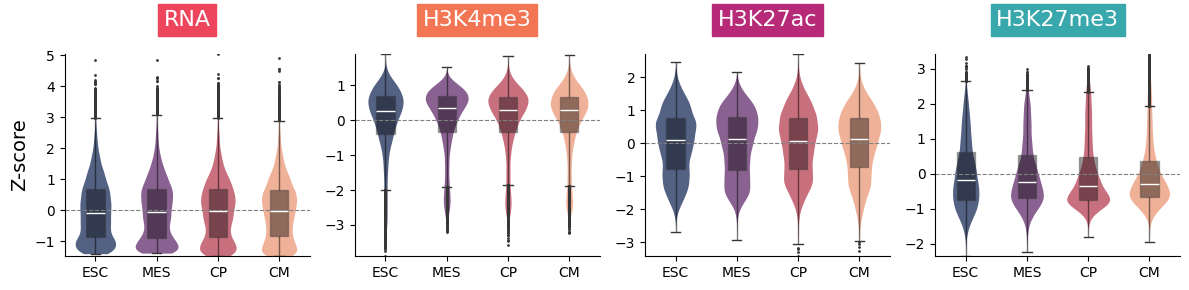

In [291]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

def plot_violin_box_grid(df, feature_groups, ct_list, hm_col_dict, ct_col_dict, k=None, x_lab='Value Distribution', vmin=None, vmax=None):
    """
    Plots violin and box plots for multiple feature groups as a grid of subplots.

    Args:
        df (pd.DataFrame): The data frame containing the data.
        feature_groups (list of str): List of feature groups to be plotted (e.g., ['H3K4me3', 'H3K27ac']).
        ct_list (list of str): List of cell types for grouping (e.g., ['ESC', 'MES', 'CP', 'CM']).
        hm_col_dict (dict): Dictionary mapping feature groups to colors.
        ct_col_dict (dict): Dictionary mapping cell types to colors.
        k (int, optional): Cluster value to filter the DataFrame by the 'Cluster' column.
        x_lab (str): Label for the x-axis.
    """

    
    fig, axes = plt.subplots(1, 4, figsize=(3 * 4, 3 ),)
    axes = axes.flatten()  # Flatten for easy indexing

    for i, feature_group in enumerate(feature_groups):
        ax = axes[i]
        
        # Filter columns specific to the feature group and the time points
        feature_columns = [f"{feature_group}_{ct}" for ct in ct_list]
        filtered_df = df[feature_columns].copy()
        VMIN, VMAX = filtered_df.min().min(), filtered_df.max().max()
        # Filter rows by cluster value if k is provided
        if k is not None:
            filtered_df = filtered_df[df['Cluster'] == k]
        
        # Melt the DataFrame to long format for plotting
        melted_df = filtered_df.melt(var_name='CT', value_name='Value')
        melted_df['CT'] = melted_df['CT'].str.replace(f"{feature_group}_", '')

        # Violin plot
        sns.violinplot(
            data=melted_df, x='CT', y='Value', palette=[ct_col_dict[ct] for ct in ct_list], hue='CT',
            ax=ax, inner=None, linewidth=0, saturation=1, cut=0, alpha=0.9, density_norm='area',common_norm=True,width=0.7
        )

        # Box plot overlay
        sns.boxplot(
            data=melted_df, x='CT', y='Value', hue='CT', 
            ax=ax, width=0.3, palette=[ct_col_dict[ct] for ct in ct_list],
            showcaps=True,
            boxprops=dict(facecolor='black', alpha=0.4, linewidth=1),
            medianprops=dict(color='white', linewidth=1),
            whiskerprops=dict(color='black', alpha=0.5),
            flierprops=dict(marker='.', markerfacecolor='grey', markersize=2, alpha=1)
        )

        # Customize plot
        ax.set_title(f'{feature_group}', fontsize=16, color='white', backgroundcolor=hm_col_dict.get(feature_group, 'black'),
                     pad=20)
        ax.axhline(0, color='grey', linestyle='--', linewidth=0.8)  # Horizontal line at y=0
        if i ==0:
            ax.set_ylabel(x_lab, fontsize=14)
        else:
            ax.set_ylabel('')
        ax.set_xlabel('')
        #ax.set_xticks([])
        ax.set_ylim(VMIN, VMAX)  # Adjust the limits as per your data range
        #ax.arrow(len(ct_list) - 1, 0, 0.1, 0, color='black', head_width=0.1, head_length=0.2, linewidth=1)

        sns.despine(ax=ax,  )



    plt.tight_layout()
    plt.show()

# Example usage
# Assuming `df` is your DataFrame containing the data and HM_LIST contains the feature groups
plot_violin_box_grid(DATA, ['RNA','H3K4me3', 'H3K27ac', 'H3K27me3'], CT_LIST, HM_COL_DICT, CT_COL_DICT,  x_lab='Z-score')


In [292]:
DATA[Z_AVG_features].quantile([0.01]).min(axis=1)[0.01]

-3.079641662812086

In [293]:
TOP5 = pd.read_csv("./data/TOP5_TermsPerCluster.csv", index_col=0)

df= TOP5[TOP5['Cluster']==76]
df

,Gene_set,Term,Odds Ratio,Genes,Cluster,Count,-log10(adj p-value)
572,GO_Biological_Process_2023,Heart Development,18.246423,FOXC2;BMP2;FOXC1;MEF2C;RAMP2;HAND2;HAND1;GATA4...,76,12,7.528240
573,GO_Biological_Process_2023,Regulation Of Angiogenesis,17.282997,FOXC1;RAMP2;BMPER;PLXND1;RHOJ;WNT5A;GATA6;KDR;...,76,12,7.528240
574,GO_Biological_Process_2023,Positive Regulation Of Angiogenesis,23.876006,FOXC2;RAMP2;BMPER;WNT5A;GATA6;KDR;HMGA2;TWIST1...,76,10,7.426148
575,GO_Biological_Process_2023,Mesenchymal Cell Differentiation,32.863321,MEF2C;FOXC1;BMP2;WNT5A;HMGA2;ISL1;BMP7,76,7,5.668533
576,GO_Biological_Process_2023,Positive Regulation Of Cell Differentiation,11.843430,FBN2;BMP2;FOXC1;MEF2C;FRZB;KDR;TWIST1;ADRA2B;B...,76,11,5.560207
577,GO_Molecular_Function_2023,DNA-binding Transcription Factor Binding,10.375546,FOXC1;MEF2C;HAND2;HAND1;LMO2;GATA6;HMGA2;TWIST...,76,11,5.375825
578,GO_Molecular_Function_2023,RNA Polymerase II-specific DNA-binding Transcr...,11.540932,FOXC1;MEF2C;HAND2;HAND1;LMO2;GATA6;HMGA2;GATA4...,76,10,5.375825
579,GO_Molecular_Function_2023,"DNA-binding Transcription Activator Activity, ...",9.004286,FOXC2;FOXC1;MEF2C;HAND2;IRX3;HAND1;HOXB3;GATA4...,76,9,4.173715
580,GO_Molecular_Function_2023,bHLH Transcription Factor Binding,49.670000,LMO2;HAND1;TWIST1;ISL1,76,4,4.173715
581,GO_Molecular_Function_2023,Transcription Regulatory Region Nucleic Acid B...,10.136036,FOXC2;FOXC1;MEF2C;HAND2;HAND1;GATA6;HMGA2;GATA4,76,8,4.173715
